# Deep learning framework example

This notebook demonstrates how to use the deeplearning API to train and test the model on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

To install the necessary software, use `make deps` in the root directory of the project.  If you don't have make installed or don't want to use it, then use:

`pip install -r src/python/requirements.txt`


## What is demoed

This notebook shows how to create an executor directly.  However, an easier more client friendly facade is available and given in the *mnist* notebook.

Also see the the *debug* notebook, which demostrates how to debug a model.

In [1]:
# set up notebook environment
import sys
app_root_dir = '..'
sys.path.append(app_root_dir + '/src/python')
sys.path.append(app_root_dir + '/test/python')

from zensols.deeplearn import TorchConfig
# set the random seed so things are predictable
TorchConfig.set_random_seed()

## Create the object factory

This creates a factoty that instantiates Python objects using a simple configuration (INI).  This removes much of the complexity of creating and "hooking up" all the instances.

In [2]:
import logging
from zensols.config import ExtendedInterpolationEnvConfig as AppConfig
from zensols.config import ImportConfigFactory
from zensols.deeplearn.result import ModelResultGrapher

# configure logging
logging.basicConfig(format='%(asctime)-15s %(name)s [%(levelname)s]: %(message)s',
                    level=logging.WARNING)
for name in ['zensols.deeplearn.result',
             'zensols.deeplearn.model.facade',
             'zensols.deeplearn.batch.stash']:
    logging.getLogger(name).setLevel(logging.INFO)

# configure the environment
config = AppConfig(app_root_dir + '/test-resources/iris/iris.conf',
                   env={'app_root': app_root_dir})

# create a factoty that instantiates Python objects using a simple configuration (INI)
factory = ImportConfigFactory(config)

## Create the model executor

Use the factory to create the model executor (see the `executor` section of `test-resources/iris/iris.conf`).  The `write` method gives statistics on the data set that is configured on the executor.

In [3]:
executor = factory('executor')
executor.write()

model: Iris
feature splits:
    data frame splits:
        dev: 12 (8.0%)
        test: 25 (16.7%)
        train: 113 (75.3%)
        total: 150
batch splits:
    split stash splits:
            dev: 1 (11.1%)
            test: 2 (22.2%)
            train: 6 (66.7%)
            total: 9
    total this instance: 9
    keys consistent: True
    delegate:
        name: batch_dataset_stash
        chunk_size: 0
        workers: 8
        batch_size: 20
        data_point_id_sets_path: ../target/iris/batch/batch-point-keys.dat
        batch_limit: 9223372036854775807
        delegate_attr: True
        _has_data: True
        is_child: False
        priming: False


## Print the model

Every time the executor is told to train, it creates a new model.  It also stores this model to the disk every time the validation loss drops.  The method that controls the creation is `_create_model`, and not meant to be called by the client.  Note this creates a new PyTorch `torch.nn.Module` every time and isn't the same instance used by the executor.

In this case, a four deep fully connected network is created and fanned out from the 4 features (from four columns from the CSV file) to 20.  This is then reduce to the output layer having three neurons indicating which type of flower (setosa, versicolor, or virginica).

In [4]:
print(executor._create_model())

IrisNetwork(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): DeepLinear(
    (dropout): Dropout(p=0.1, inplace=False)
    (lin_layers): Sequential(
      (0): Linear(in_features=4, out_features=5, bias=True)
      (1): Linear(in_features=5, out_features=1, bias=True)
      (2): Linear(in_features=1, out_features=3, bias=True)
    )
  )
)


## Train and test the model

This trains the model on the Iris (flower) data set and prints the results.  The PyTorch model itself is also printed.

2020-09-16 21:13:35,914 zensols.deeplearn.batch.stash [INFO]: loaded batch 3 (train) in 0s
2020-09-16 21:13:35,918 zensols.deeplearn.batch.stash [INFO]: loaded batch 4 (train) in 0s
2020-09-16 21:13:35,921 zensols.deeplearn.batch.stash [INFO]: loaded batch 5 (train) in 0s
2020-09-16 21:13:35,924 zensols.deeplearn.batch.stash [INFO]: loaded batch 6 (train) in 0s
2020-09-16 21:13:35,928 zensols.deeplearn.batch.stash [INFO]: loaded batch 7 (train) in 0s
2020-09-16 21:13:35,930 zensols.deeplearn.batch.stash [INFO]: loaded batch 8 (train) in 0s
2020-09-16 21:13:38,600 zensols.deeplearn.batch.stash [INFO]: loaded batch 0 (dev) in 0s
tr:8.114|va min:3.489|va:5.261 /\:  93%|██████▌| 14/15 [00:00<00:00, 56.38it/s]2020-09-16 21:13:38,888 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0s
2020-09-16 21:13:38,890 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0s
tr:8.114|va min:3.489|va:5.261 /\: 100%|███████| 15/15 [00:00<00:00, 48.40it/s]


Name: Iris: 1
Run index: 2
Learning rate: 0.1
    train:
        started: 09/16/2020 21:13:38:604986
        ended: 09/16/2020 21:13:38:871539
        batches: 6
        ave data points per batch: 18.8
        converged/epochs: 14/15
        ave/min loss: 7.18044/2.50566
        accuracy: 0.673 (76/113)
        micro: F1: 0.673, precision: 0.673, recall: 0.673
        macro: F1: 0.632, precision: 0.696, recall: 0.679
    validation:
        batches: 1
        ave data points per batch: 12.0
        converged/epochs: 14/15
        ave/min loss: 3.48851/3.48851
        accuracy: 0.750 (9/12)
        micro: F1: 0.750, precision: 0.750, recall: 0.750
        macro: F1: 0.608, precision: 0.567, recall: 0.667
    test:
        started: 09/16/2020 21:13:38:892579
        ended: 09/16/2020 21:13:38:893902
        batches: 2
        ave data points per batch: 12.5
        converged/epochs: 1/1
        ave/min loss: 4.50519/2.13488
        accuracy: 0.640 (16/25)
        micro: F1: 0.640, precis

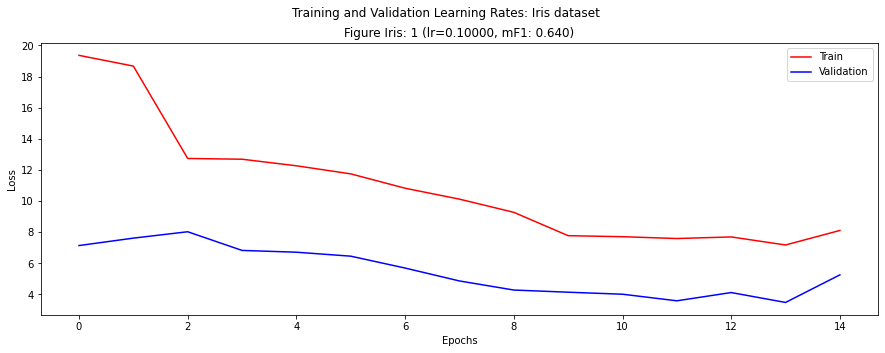

In [5]:
# tell the executor to give us console output
executor.progress_bar = True

# train the model
executor.train()

# test the model
res = executor.test()

# write a summary of the results
res.write()

# graph the results
grapher = ModelResultGrapher('Iris dataset', [15, 5])
grapher.plot([res])

## Create the model facade

An easier wasy to use the executor is with a *facade*.  A `ModelFacade` provides easy to use client entry points to the model executor, which trains, validates, tests, saves and loads the model.  Create the facade with a factory, which in turn creates the executor.  The statistics on the data set that is configured on the executor is, by default, printed to standard out.  You can set the `writer` property to `None` on the facade to disable this.

In [6]:
from dataclasses import dataclass
from zensols.deeplearn.model import ModelFacade

@dataclass
class IrisModelFacade(ModelFacade):
    def _configure_debug_logging(self):
        super()._configure_debug_logging()
        logging.getLogger('iris.model').setLevel(logging.DEBUG)
        
# deallocate the previous executor
executor.deallocate()
# create the facade
facade = IrisModelFacade(config)

## Fine tune setting hyperparameters

Now that we have our model training and we have evaluated the results, we see the validation loss is very spiky.  This means our learning rate is probably too high as when it moves during stochastic gradient descent it is "jumping" too far and back up the error surface.

To fix that, let's decrease the learning rate.  We can do that by adjusting the hyperparameters directly on the facade.  In fact, the purpose of the facade is to make changes easily such as this.

Notice that the facade prints the output with a correctly configured scroll bar by default.  Output can be disabled by setting the `writer` attribute/initializer parameter to `None`.  The progress bar and columns are set with the `progress_bar` and `progress_bar_col` attributes.

In [7]:
# set the number of epochs and learning rate, which are both model parameters
facade.epochs = 20
facade.learning_rate = .01
# train and test the model
facade.train()
facade.test()
# display the results in this cell
facade.write_result()

2020-09-16 21:13:39,215 zensols.deeplearn.model.facade [INFO]: creating new executor
2020-09-16 21:13:39,232 zensols.deeplearn.model.facade [INFO]: training...
2020-09-16 21:13:39,237 zensols.deeplearn.batch.stash [INFO]: loaded batch 3 (train) in 0s
2020-09-16 21:13:39,240 zensols.deeplearn.batch.stash [INFO]: loaded batch 4 (train) in 0s
2020-09-16 21:13:39,243 zensols.deeplearn.batch.stash [INFO]: loaded batch 5 (train) in 0s
2020-09-16 21:13:39,247 zensols.deeplearn.batch.stash [INFO]: loaded batch 6 (train) in 0s
2020-09-16 21:13:39,250 zensols.deeplearn.batch.stash [INFO]: loaded batch 7 (train) in 0s
2020-09-16 21:13:39,252 zensols.deeplearn.batch.stash [INFO]: loaded batch 8 (train) in 0s
2020-09-16 21:13:39,257 zensols.deeplearn.batch.stash [INFO]: loaded batch 0 (dev) in 0s
tr:12.261|va min:8.260|va:8.198 \/:  40%|██▊    | 8/20 [00:00<00:00, 59.75it/s]

model: Iris
feature splits:
    data frame splits:
        dev: 12 (8.0%)
        test: 25 (16.7%)
        train: 113 (75.3%)
        total: 150
batch splits:
    split stash splits:
            dev: 1 (11.1%)
            test: 2 (22.2%)
            train: 6 (66.7%)
            total: 9
    total this instance: 9
    keys consistent: True
    delegate:
        name: batch_dataset_stash
        chunk_size: 0
        workers: 8
        batch_size: 20
        data_point_id_sets_path: ../target/iris/batch/batch-point-keys.dat
        batch_limit: 9223372036854775807
        delegate_attr: True
        _has_data: True
        is_child: False
        priming: False


tr:11.738|va min:7.794|va:7.741 \/:  95%|█████▋| 19/20 [00:00<00:00, 53.09it/s]2020-09-16 21:13:39,672 zensols.deeplearn.model.facade [INFO]: trained in 0s
tr:11.738|va min:7.794|va:7.741 \/: 100%|██████| 20/20 [00:00<00:00, 48.16it/s]
2020-09-16 21:13:39,684 zensols.deeplearn.model.facade [INFO]: testing...
2020-09-16 21:13:39,687 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0s
2020-09-16 21:13:39,689 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0s
2020-09-16 21:13:39,693 zensols.deeplearn.model.facade [INFO]: trained in 0s
2020-09-16 21:13:39,712 zensols.deeplearn.model.facade [INFO]: load previous results


Name: Iris: 1
Run index: 2
Learning rate: 0.01
    train:
        started: 09/16/2020 21:13:39:260701
        ended: 09/16/2020 21:13:39:657273
        batches: 6
        ave data points per batch: 18.8
        converged/epochs: 20/20
        ave/min loss: 11.73842/9.11475
        accuracy: 0.442 (50/113)
        micro: F1: 0.442, precision: 0.442, recall: 0.442
        macro: F1: 0.380, precision: 0.370, recall: 0.434
    validation:
        batches: 1
        ave data points per batch: 12.0
        converged/epochs: 20/20
        ave/min loss: 7.74129/7.74129
        accuracy: 0.417 (5/12)
        micro: F1: 0.417, precision: 0.417, recall: 0.417
        macro: F1: 0.487, precision: 0.433, recall: 0.667
    test:
        started: 09/16/2020 21:13:39:691774
        ended: 09/16/2020 21:13:39:693174
        batches: 2
        ave data points per batch: 12.5
        converged/epochs: 1/1
        ave/min loss: 7.49526/3.45382
        accuracy: 0.720 (18/25)
        micro: F1: 0.720, prec

## Network parameters

While we're at it, let's also adjust the drop out, which is a network settings, to see if we can get better results.  Also note that the model converged pretty late indicating we aren't over training, so add more epochs.

2020-09-16 21:13:39,739 zensols.deeplearn.model.facade [INFO]: training...
tr:6.734|va min:3.081|va:3.232 /\: 100%|███▉| 999/1000 [00:21<00:00, 78.74it/s]2020-09-16 21:14:01,685 zensols.deeplearn.model.facade [INFO]: trained in 21s
tr:6.734|va min:3.081|va:3.232 /\: 100%|███| 1000/1000 [00:21<00:00, 45.57it/s]
2020-09-16 21:14:01,921 zensols.deeplearn.model.facade [INFO]: testing...
2020-09-16 21:14:01,924 zensols.deeplearn.model.facade [INFO]: trained in 0s
2020-09-16 21:14:01,924 zensols.deeplearn.model.facade [INFO]: load previous results


Name: Iris: 1
Run index: 2
Learning rate: 0.005
    train:
        started: 09/16/2020 21:13:39:743315
        ended: 09/16/2020 21:14:01:152350
        batches: 6
        ave data points per batch: 18.8
        converged/epochs: 760/1000
        ave/min loss: 5.55785/2.85951
        accuracy: 0.885 (100/113)
        micro: F1: 0.885, precision: 0.885, recall: 0.885
        macro: F1: 0.881, precision: 0.900, recall: 0.888
    validation:
        batches: 1
        ave data points per batch: 12.0
        converged/epochs: 844/1000
        ave/min loss: 3.08125/3.08125
        accuracy: 1.000 (12/12)
        micro: F1: 1.000, precision: 1.000, recall: 1.000
        macro: F1: 1.000, precision: 1.000, recall: 1.000
    test:
        started: 09/16/2020 21:14:01:922689
        ended: 09/16/2020 21:14:01:924076
        batches: 2
        ave data points per batch: 12.5
        converged/epochs: 1/1
        ave/min loss: 3.56373/1.14945
        accuracy: 0.880 (22/25)
        micro: F1: 0.8

2020-09-16 21:14:02,423 zensols.deeplearn.result.manager [INFO]: copying model ../target/iris/model -> ../target/iris/results/iris-5.model
2020-09-16 21:14:02,427 zensols.deeplearn.result.manager [INFO]: saving text results to ../target/iris/results/iris-5.txt
2020-09-16 21:14:02,737 zensols.deeplearn.result.manager [INFO]: saving json results to ../target/iris/results/iris-5.json
2020-09-16 21:14:03,041 zensols.deeplearn.result.plot [INFO]: saving results graph to ../target/iris/results/iris-5.png


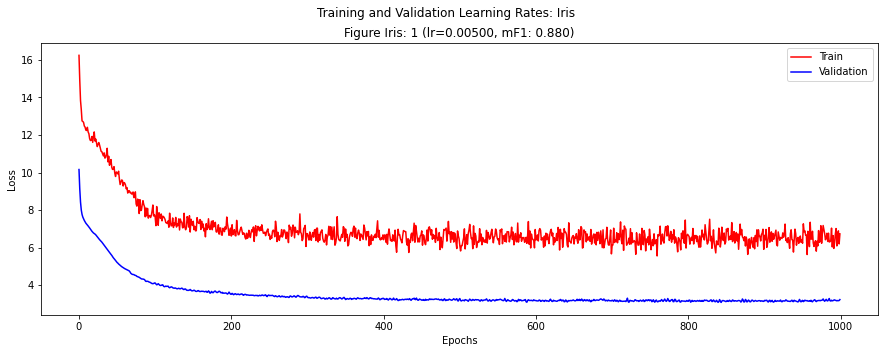

In [8]:
# turn off output so we can get just the final results later with `write_result`
facade.writer = None
# set network parameter `dropout` and model settings to achieve better performance
facade.dropout = 0.1
# set lower learning rate and compensate with epochs in case learning is slower
facade.epochs = 1000
facade.learning_rate = .005
# train and test again
facade.train()
facade.test()
# display the results in this cell
facade.write_result()
# plot results
facade.plot_result()
# now since we like our results, save them to disk
facade.persist_result()

## Predictions

The executor contains the results from the last run, in additional to saving it.  In our case, we have the same instance of the model we just tested, which contains not only the performance metrics, but the predictions themselves.  Use `get_predictions` to get a Pandas `pd.DataFrame` for the results.

In [9]:
from iris.model import IrisDataPoint

# optionally, we can transform the data point instance used, otherwise it defaults to `str`
def map_data_point(dp: IrisDataPoint):
    """Map the data point's Pandas row information (pd.Series) to key/value string.
    
    :param dp: the data point created by the ``iris_dataset_stash`` as defined in the configuration
    
    """
    s = ', '.join(map(lambda x: f'{x[0]}={x[1]}', dp.row.iteritems()))
    return dp.row['sepal_length'], dp.row['sepal_width'], dp.row['petal_length'], dp.row['petal_width']
facade.get_predictions(column_names=['sepal length', 'sepal width', 'petal length', 'petal width'], transform=map_data_point)

2020-09-16 21:14:03,362 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0s
2020-09-16 21:14:03,380 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0s


,id,label,pred,correct,sepal length,sepal width,petal length,petal width
0,17,setosa,setosa,True,5.1,3.5,1.4,0.3
1,30,setosa,setosa,True,4.8,3.1,1.6,0.2
2,31,setosa,setosa,True,5.4,3.4,1.5,0.4
3,33,setosa,setosa,True,5.5,4.2,1.4,0.2
4,41,setosa,setosa,True,4.5,2.3,1.3,0.3
5,43,setosa,setosa,True,5.0,3.5,1.6,0.6
6,45,setosa,setosa,True,4.8,3.0,1.4,0.3
7,46,setosa,setosa,True,5.1,3.8,1.6,0.2
8,48,setosa,setosa,True,5.3,3.7,1.5,0.2
9,49,setosa,setosa,True,5.0,3.3,1.4,0.2


In [10]:
from zensols.persist import dealloc
from zensols.deeplearn.model import ModelFacade
from pathlib import Path

# deallocate the previous facade
facade.deallocate()
path = Path('../target/iris/results/iris-1.model')
# create a new facade wrapped in a deallocation block
# (it will be deallocated even in an error generated in the block)
with dealloc(ModelFacade.load_from_path(path)) as facade:
    facade.write_result()
# note that no test results are given since this model was saved during
# training after achieving the lowest validation loss

2020-09-16 21:14:03,429 zensols.deeplearn.model.facade [INFO]: loading from facade from ../target/iris/results/iris-1.model
2020-09-16 21:14:03,881 zensols.deeplearn.model.facade [INFO]: load previous results


Name: Iris: 1
Run index: 2
Learning rate: 0.005
    train:
        started: 09/03/2020 18:27:23:484620
        ended: 09/03/2020 18:27:45:284088
        batches: 6
        ave data points per batch: 18.8
        converged/epochs: 760/1000
        ave/min loss: 5.55785/2.85951
        accuracy: 0.885 (100/113)
        micro: F1: 0.885, precision: 0.885, recall: 0.885
        macro: F1: 0.881, precision: 0.900, recall: 0.888
    validation:
        batches: 1
        ave data points per batch: 12.0
        converged/epochs: 844/1000
        ave/min loss: 3.08125/3.08125
        accuracy: 1.000 (12/12)
        micro: F1: 1.000, precision: 1.000, recall: 1.000
        macro: F1: 1.000, precision: 1.000, recall: 1.000
    test:
        no results


In [11]:
# we can also revive the model as a facade to test, then we'll get the test results
with dealloc(ModelFacade.load_from_path(path)) as facade:
    facade.writer = None
    facade.test()
    facade.write_result(include_converged=True)

2020-09-16 21:14:03,911 zensols.deeplearn.model.facade [INFO]: loading from facade from ../target/iris/results/iris-1.model
2020-09-16 21:14:04,547 zensols.deeplearn.model.facade [INFO]: testing...
2020-09-16 21:14:04,555 zensols.deeplearn.batch.stash [INFO]: loaded batch 1 (test) in 0s
2020-09-16 21:14:04,557 zensols.deeplearn.batch.stash [INFO]: loaded batch 2 (test) in 0s
2020-09-16 21:14:04,561 zensols.deeplearn.model.facade [INFO]: trained in 0s
2020-09-16 21:14:04,562 zensols.deeplearn.model.facade [INFO]: load previous results


Name: Iris: 1
Run index: 2
Learning rate: 0.005
    train:
        started: 09/16/2020 21:13:39:743315
        ended: 09/16/2020 21:14:01:152350
        batches: 6
        ave data points per batch: 18.8
        converged/epochs: 760/1000
        average over epoch:
            ave/min loss: 1.16664/2.85951
            accuracy: 0.761 (86032/113000)
            micro: F1: 0.761, precision: 0.761, recall: 0.761
            macro: F1: 0.755, precision: 0.767, recall: 0.765
            epoch details:
                index: 0
                batch IDs: 3,4,5,6,7,8
                data point count per batch: 20,20,20,20,20,13
        converged epoch:
            ave/min loss: 5.55785/2.85951
            accuracy: 0.885 (100/113)
            micro: F1: 0.885, precision: 0.885, recall: 0.885
            macro: F1: 0.881, precision: 0.900, recall: 0.888
    validation:
        batches: 1
        ave data points per batch: 12.0
        converged/epochs: 844/1000
        average over epoch:
    